In [ ]:
#%% 
#Imports

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
)

rng = np.random.RandomState(42)

In [ ]:
#%% 
#Load the MNIST data

X_mnist, y_mnist = fetch_openml(
    name="mnist_784",
    return_X_y=True,
    as_frame=False,
)

# Ensure labels are integers 0–9
y_mnist = y_mnist.astype(int)

print("X_mnist shape:", X_mnist.shape)
print("y_mnist shape:", y_mnist.shape)
print("Unique labels:", np.unique(y_mnist))

X_mnist shape: (70000, 784)
y_mnist shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


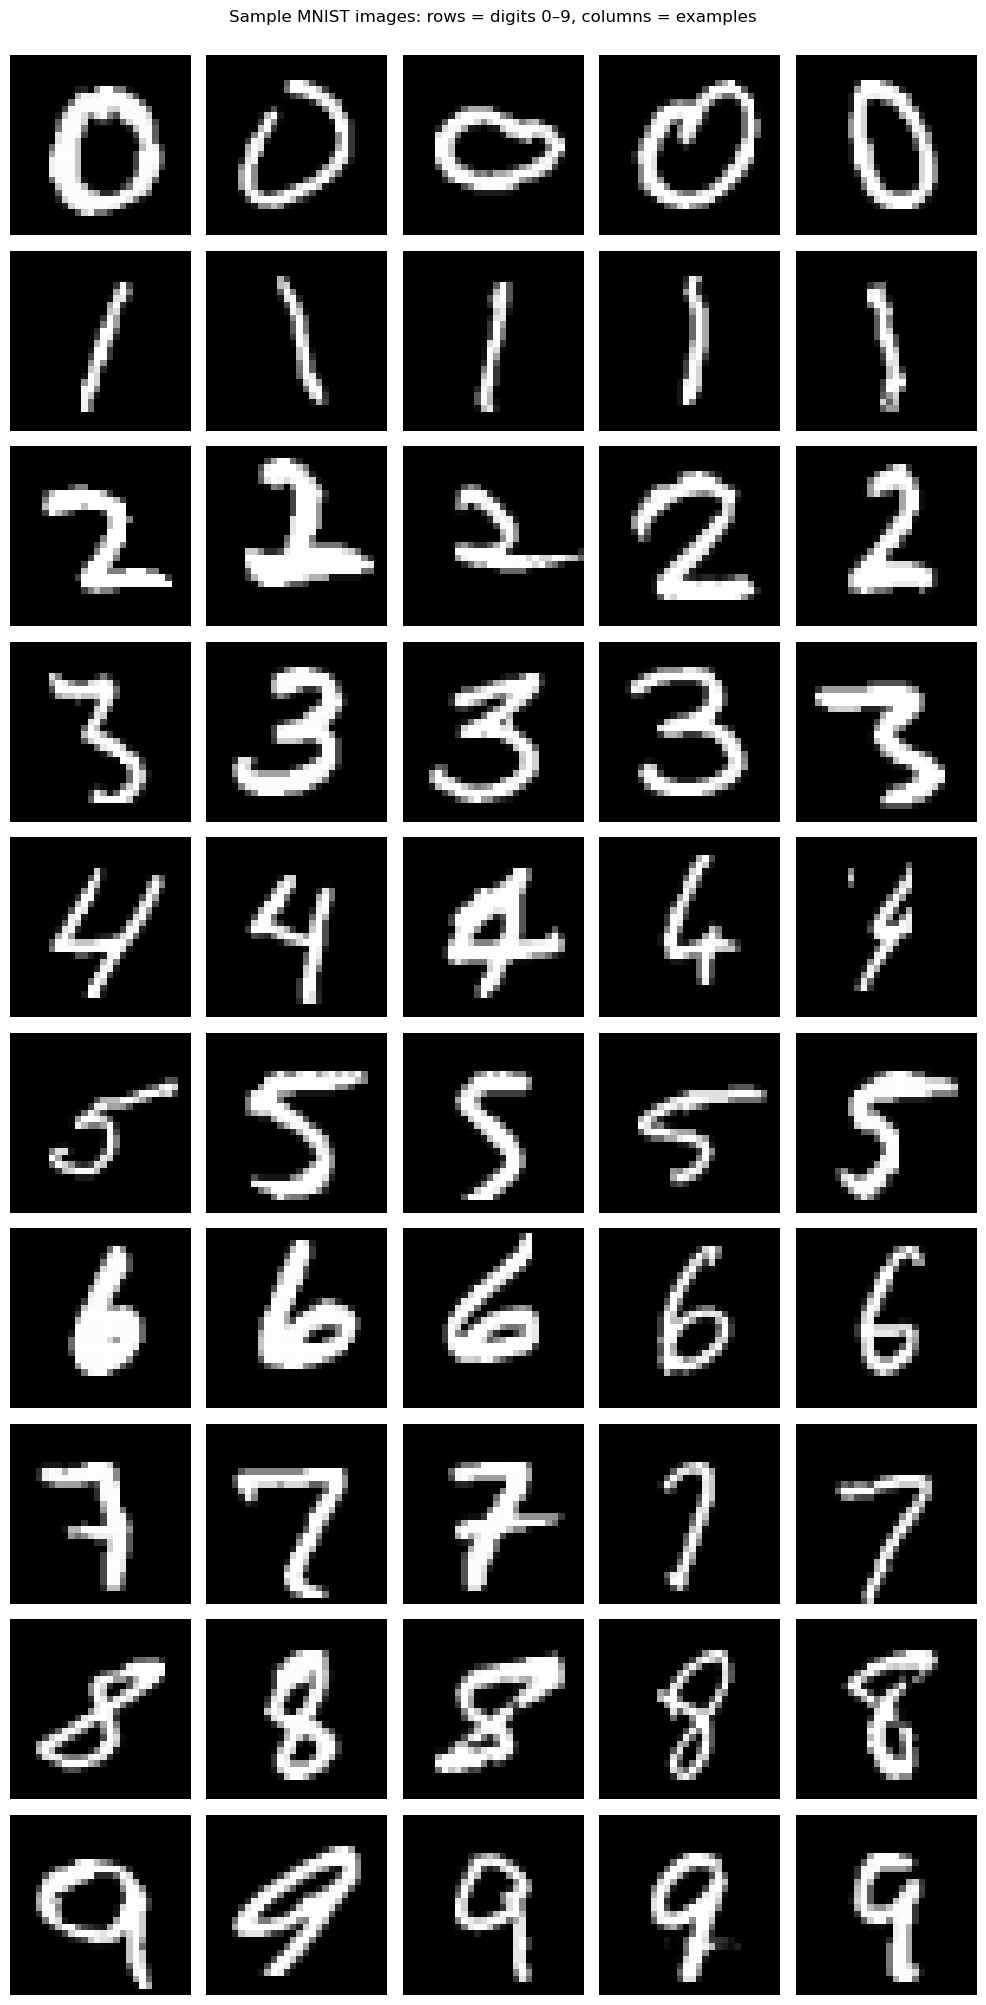

In [ ]:
#%% 
#Visualise sample images: 1 row per digit and 5 images per digit

n_classes = 10
samples_per_class = 5
img_size = 28

fig, axes = plt.subplots(
    n_classes,
    samples_per_class,
    figsize=(samples_per_class * 2, n_classes * 2),
)

for digit in range(n_classes):
    idx = np.where(y_mnist == digit)[0]
    chosen = rng.choice(idx, size=samples_per_class, replace=False)

    for j, i in enumerate(chosen):
        ax = axes[digit, j]
        ax.imshow(X_mnist[i].reshape(img_size, img_size), cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(str(digit), rotation=0, labelpad=20, fontsize=10)

plt.suptitle("Sample MNIST images: rows = digits 0–9, columns = examples", y=1)
plt.tight_layout()
plt.show()


In [6]:
#%% 
# PCA for dimensionality reduction

# Choose a reasonable number of PCA components
n_components_pca = 50

pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X_mnist)

print("Original dimensionality:", X_mnist.shape[1])
print("Reduced dimensionality:", X_pca.shape[1])


Original dimensionality: 784
Reduced dimensionality: 50


In [16]:
#%% 
# K-Means experiments with different hyperparameters:
#  * n_clusters
#  * n_init

kmeans_results = []
best_kmeans_model = None
best_kmeans_config = None
best_kmeans_score = -np.inf  # we will rank by NMI

n_clusters_list = [8, 10, 12]
n_init_list = [10, 20]

for n_clusters in n_clusters_list:
    for n_init in n_init_list:
        print(f"Training KMeans: n_clusters={n_clusters}, n_init={n_init} ...")
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=n_init,
            random_state=42,
        )
        labels = kmeans.fit_predict(X_pca)

        ari, nmi, sil = evaluate_clustering(X_pca, y_mnist, labels)
        kmeans_results.append(
            {
                "n_clusters": n_clusters,
                "n_init": n_init,
                "ARI": ari,
                "NMI": nmi,
                "Silhouette": sil,
            }
        )

        print(
            f" -> ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}"
        )

        if nmi > best_kmeans_score:
            best_kmeans_score = nmi
            best_kmeans_model = kmeans
            best_kmeans_config = {
                "n_clusters": n_clusters,
                "n_init": n_init,
            }

print("\nBest KMeans configuration (by NMI):", best_kmeans_config)
print("Best KMeans NMI:", best_kmeans_score)


Training KMeans: n_clusters=8, n_init=10 ...
 -> ARI=0.3956, NMI=0.5054, Silhouette=0.0998
Training KMeans: n_clusters=8, n_init=20 ...
 -> ARI=0.3955, NMI=0.5055, Silhouette=0.0963
Training KMeans: n_clusters=10, n_init=10 ...
 -> ARI=0.3648, NMI=0.4982, Silhouette=0.0893
Training KMeans: n_clusters=10, n_init=20 ...
 -> ARI=0.3648, NMI=0.4983, Silhouette=0.0817
Training KMeans: n_clusters=12, n_init=10 ...
 -> ARI=0.3508, NMI=0.5012, Silhouette=0.0872
Training KMeans: n_clusters=12, n_init=20 ...
 -> ARI=0.3508, NMI=0.5013, Silhouette=0.0879

Best KMeans configuration (by NMI): {'n_clusters': 8, 'n_init': 20}
Best KMeans NMI: 0.5054886654915287


In [ ]:
#%% 
#Results of K-Means in a table

import pandas as pd

kmeans_df = pd.DataFrame(kmeans_results)
print(kmeans_df.sort_values(by="NMI", ascending=False).reset_index(drop=True))


   n_clusters  n_init       ARI       NMI  Silhouette
0           8      20  0.395518  0.505489    0.098434
1           8      10  0.395596  0.505380    0.098207
2          12      20  0.350812  0.501273    0.086474
3          12      10  0.350800  0.501249    0.090569
4          10      20  0.364772  0.498265    0.088510
5          10      10  0.364803  0.498244    0.090167


In [ ]:
#%% 
#GMM experiments with different hyperparameters with n_components and covariance_type

gmm_results = []
best_gmm_model = None
best_gmm_config = None
best_gmm_score = -np.inf  

n_components_list = [8, 10, 12]
covariance_types = ["full", "diag"]

for n_components in n_components_list:
    for cov_type in covariance_types:
        print(
            f"Training GMM: n_components={n_components}, "
            f"covariance_type={cov_type} ..."
        )
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=cov_type,
            random_state=42,
        )
        gmm.fit(X_pca)
        labels = gmm.predict(X_pca)

        ari, nmi, sil = evaluate_clustering(X_pca, y_mnist, labels)
        gmm_results.append(
            {
                "n_components": n_components,
                "covariance_type": cov_type,
                "ARI": ari,
                "NMI": nmi,
                "Silhouette": sil,
            }
        )

        print(
            f" -> ARI={ari:.4f}, NMI={nmi:.4f}, Silhouette={sil:.4f}"
        )

        if nmi > best_gmm_score:
            best_gmm_score = nmi
            best_gmm_model = gmm
            best_gmm_config = {
                "n_components": n_components,
                "covariance_type": cov_type,
            }

print("\nBest GMM configuration (by NMI):", best_gmm_config)
print("Best GMM NMI:", best_gmm_score)


Training GMM: n_components=8, covariance_type=full ...
 -> ARI=0.4396, NMI=0.5874, Silhouette=0.0507
Training GMM: n_components=8, covariance_type=diag ...
 -> ARI=0.2500, NMI=0.4562, Silhouette=0.0395
Training GMM: n_components=10, covariance_type=full ...
 -> ARI=0.4482, NMI=0.6164, Silhouette=0.0480
Training GMM: n_components=10, covariance_type=diag ...
 -> ARI=0.2422, NMI=0.4704, Silhouette=0.0268
Training GMM: n_components=12, covariance_type=full ...
 -> ARI=0.4268, NMI=0.6010, Silhouette=0.0386
Training GMM: n_components=12, covariance_type=diag ...
 -> ARI=0.2682, NMI=0.4872, Silhouette=0.0330

Best GMM configuration (by NMI): {'n_components': 10, 'covariance_type': 'full'}
Best GMM NMI: 0.6164079412033795


In [11]:
#%% 
# Summarise GMM results in a simple table

gmm_df = pd.DataFrame(gmm_results)
print(gmm_df.sort_values(by="NMI", ascending=False).reset_index(drop=True))


   n_components covariance_type       ARI       NMI  Silhouette
0            10            full  0.448237  0.616408    0.048020
1            12            full  0.426793  0.601010    0.038618
2             8            full  0.439603  0.587369    0.050717
3            12            diag  0.268237  0.487249    0.033019
4            10            diag  0.242190  0.470425    0.026784
5             8            diag  0.250045  0.456222    0.039504


In [12]:
#%% 
# Compare best K-Means and best GMM based on NMI

print("Best KMeans (NMI):", best_kmeans_score, "config:", best_kmeans_config)
print("Best GMM   (NMI):", best_gmm_score, "config:", best_gmm_config)

if best_kmeans_score >= best_gmm_score:
    best_model_name = "KMeans"
    best_model = best_kmeans_model
    best_labels = best_kmeans_model.labels_
else:
    best_model_name = "GMM"
    best_model = best_gmm_model
    best_labels = best_gmm_model.predict(X_pca)

print("\nOverall best model:", best_model_name)


Best KMeans (NMI): 0.5054886654915287 config: {'n_clusters': 8, 'n_init': 20}
Best GMM   (NMI): 0.6164079412033795 config: {'n_components': 10, 'covariance_type': 'full'}

Overall best model: GMM


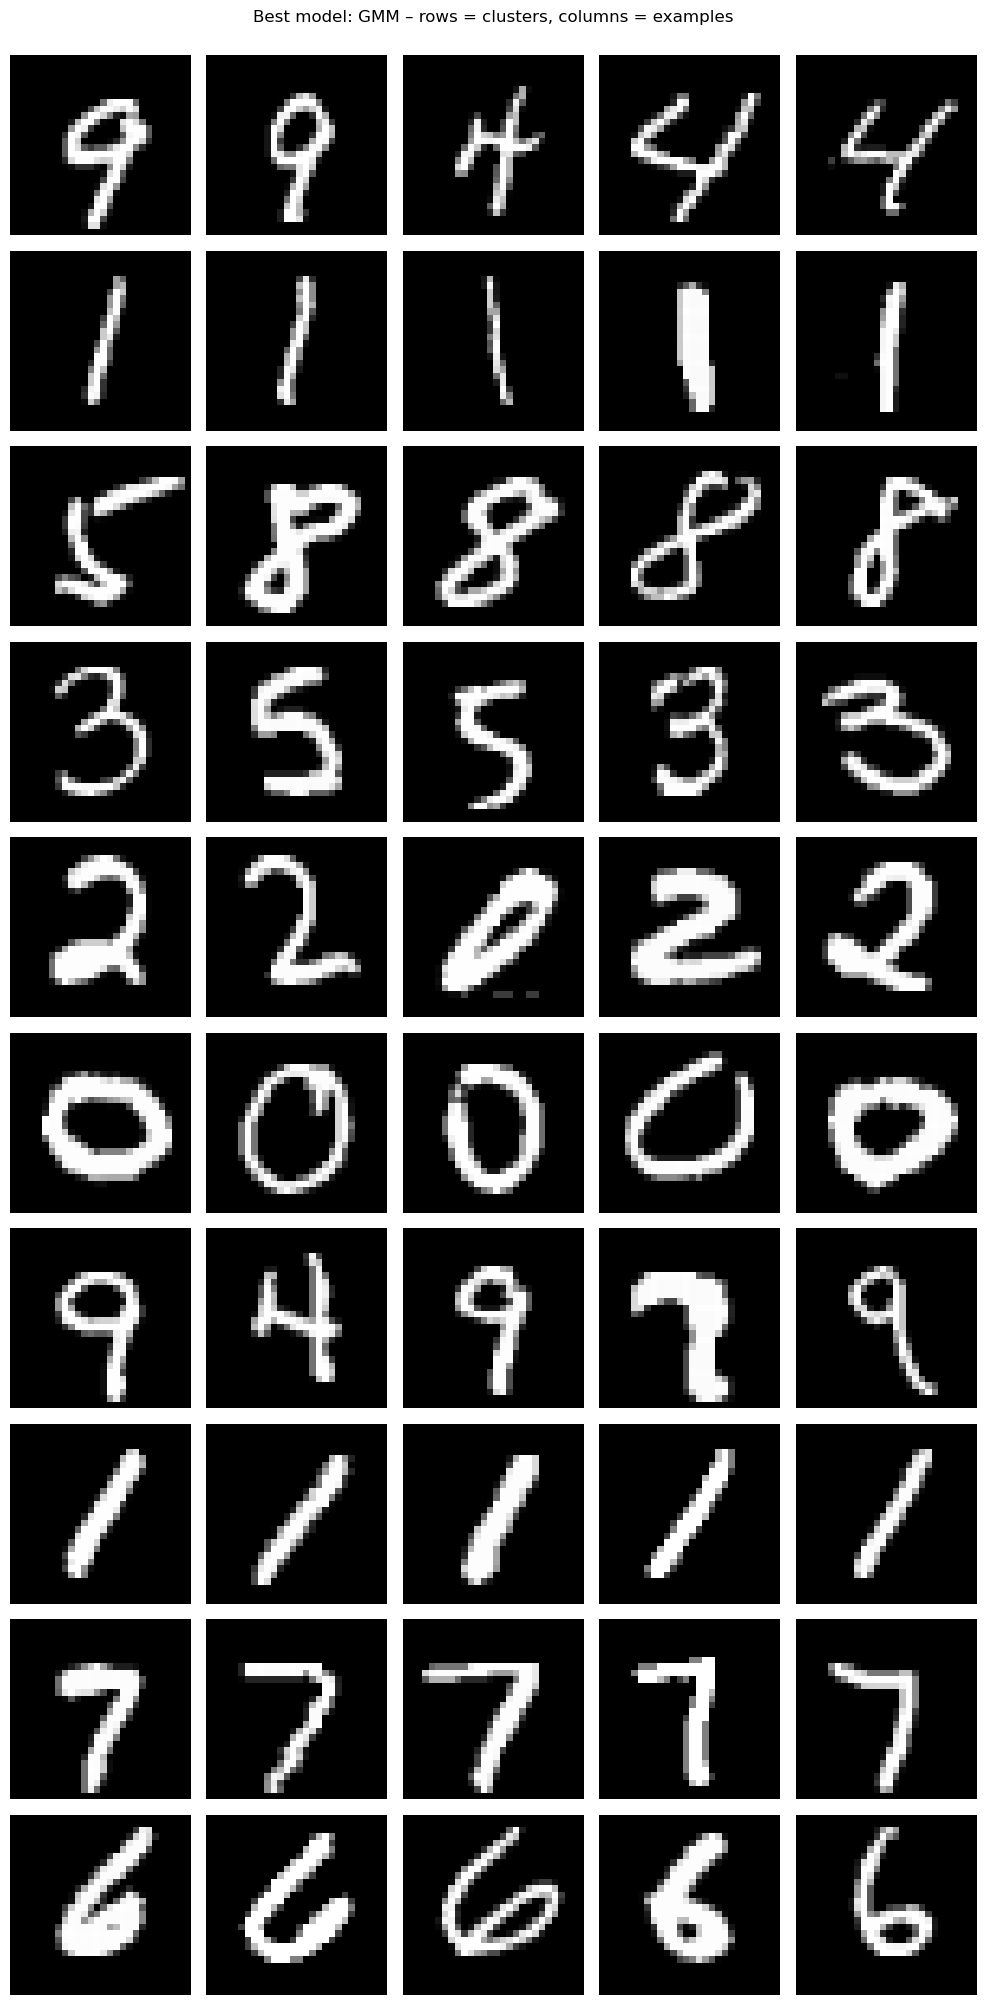

In [15]:
#%% 
# Visualise clustering results for the best model:
# one row per cluster, five images per cluster

unique_clusters = np.unique(best_labels)
n_clusters_best = unique_clusters.shape[0]
samples_per_cluster = 5

fig, axes = plt.subplots(
    n_clusters_best,
    samples_per_cluster,
    figsize=(samples_per_cluster * 2, n_clusters_best * 2),
)

for k in range(n_clusters_best):
    cluster_idx = np.where(best_labels == k)[0]

    if cluster_idx.size == 0:
        # empty cluster (unlikely but possible); skip
        for j in range(samples_per_cluster):
            ax = axes[k, j]
            ax.axis("off")
        continue

    # if cluster has fewer than required samples, use replace=True
    replace = cluster_idx.size < samples_per_cluster
    chosen = rng.choice(
        cluster_idx,
        size=samples_per_cluster,
        replace=replace,
    )

    for j, i in enumerate(chosen):
        ax = axes[k, j]
        ax.imshow(X_mnist[i].reshape(img_size, img_size), cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(f"C{k}", rotation=0, labelpad=20, fontsize=10)

plt.suptitle(
    f"Best model: {best_model_name} – rows = clusters, columns = examples",
    y=1,
)
plt.tight_layout()
plt.show()
